# PyMC set-up

Walk through as per the installation instructions
https://www.pymc.io/projects/docs/en/latest/learn/core_notebooks/pymc_overview.html

In [1]:
import arviz as az
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import sqlalchemy as sa

In [5]:
%config InlineBackend.figure_format = 'retina'
# Initialize random number generator
RANDOM_SEED = 8927
rng = np.random.default_rng(RANDOM_SEED)
az.style.use("arviz-darkgrid")

In [6]:
# True parameter values
alpha, sigma = 1, 1
beta = [1, 2.5]

# Size of dataset
size = 100

# Predictor variable
X1 = np.random.randn(size)
X2 = np.random.randn(size) * 0.2

# Simulate outcome variable
Y = alpha + beta[0] * X1 + beta[1] * X2 + rng.normal(size=size) * sigma

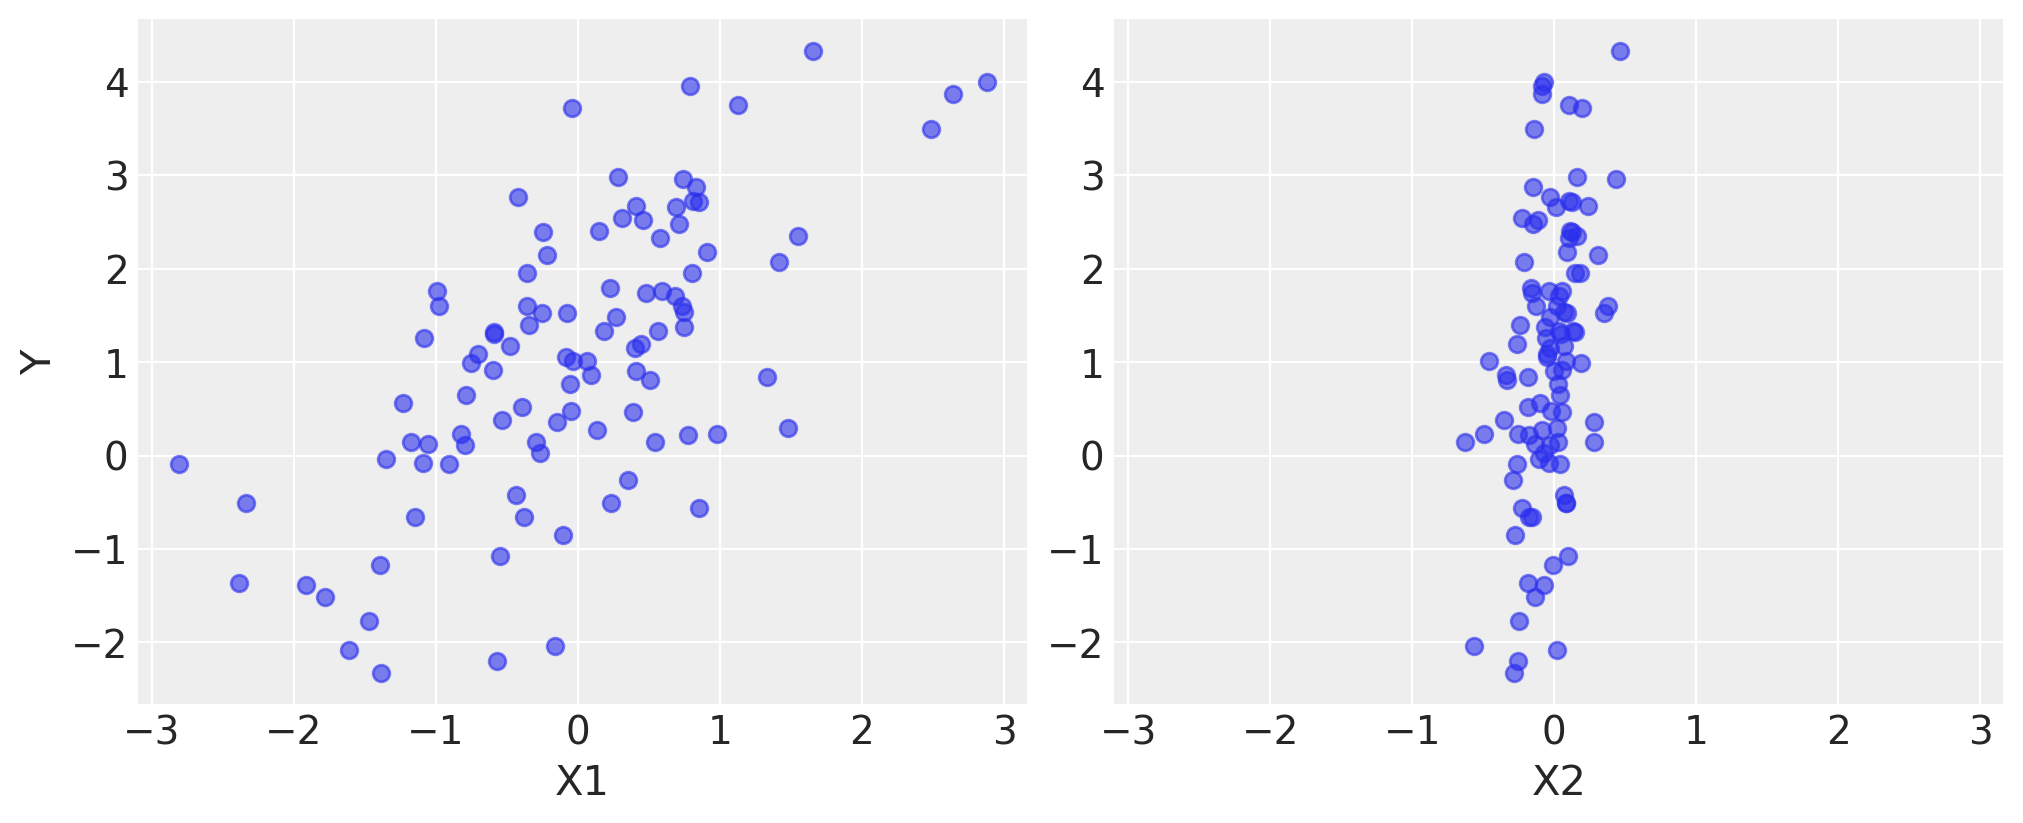

In [7]:
fig, axes = plt.subplots(1, 2, sharex=True, figsize=(10, 4))
axes[0].scatter(X1, Y, alpha=0.6)
axes[1].scatter(X2, Y, alpha=0.6)
axes[0].set_ylabel("Y")
axes[0].set_xlabel("X1")
axes[1].set_xlabel("X2");

In [10]:
import pymc as pm

print(f"Running on PyMC v{pm.__version__}")

Running on PyMC v4.2.2


In [11]:
basic_model = pm.Model()

with basic_model:

    # Priors for unknown model parameters
    alpha = pm.Normal("alpha", mu=0, sigma=10)
    beta = pm.Normal("beta", mu=0, sigma=10, shape=2)
    sigma = pm.HalfNormal("sigma", sigma=1)

    # Expected value of outcome
    mu = alpha + beta[0] * X1 + beta[1] * X2

    # Likelihood (sampling distribution) of observations
    Y_obs = pm.Normal("Y_obs", mu=mu, sigma=sigma, observed=Y)

In [12]:
with basic_model:
    # draw 1000 posterior samples
    idata = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 7 seconds.


In [13]:
idata

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data

In [14]:
idata.posterior["alpha"].sel(draw=slice(0, 4))

<xarray.DataArray 'alpha' (chain: 4, draw: 5)>
array([[1.22182606, 1.06122449, 1.19960544, 1.11622334, 1.17347533],
       [1.33032996, 1.06347311, 1.07428442, 1.12094194, 1.28404611],
       [0.99688654, 1.25084385, 1.05605624, 1.28236762, 1.28115075],
       [1.15648514, 1.09849708, 1.05702968, 1.23564325, 1.16488626]])
Coordinates:
  * chain    (chain) int64 0 1 2 3
  * draw     (draw) int64 0 1 2 3 4

In [15]:
with basic_model:
    # instantiate sampler
    step = pm.Slice()

    # draw 5000 posterior samples
    slice_idata = pm.sample(5000, step=step)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Slice: [alpha]
>Slice: [beta]
>Slice: [sigma]


Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 9 seconds.


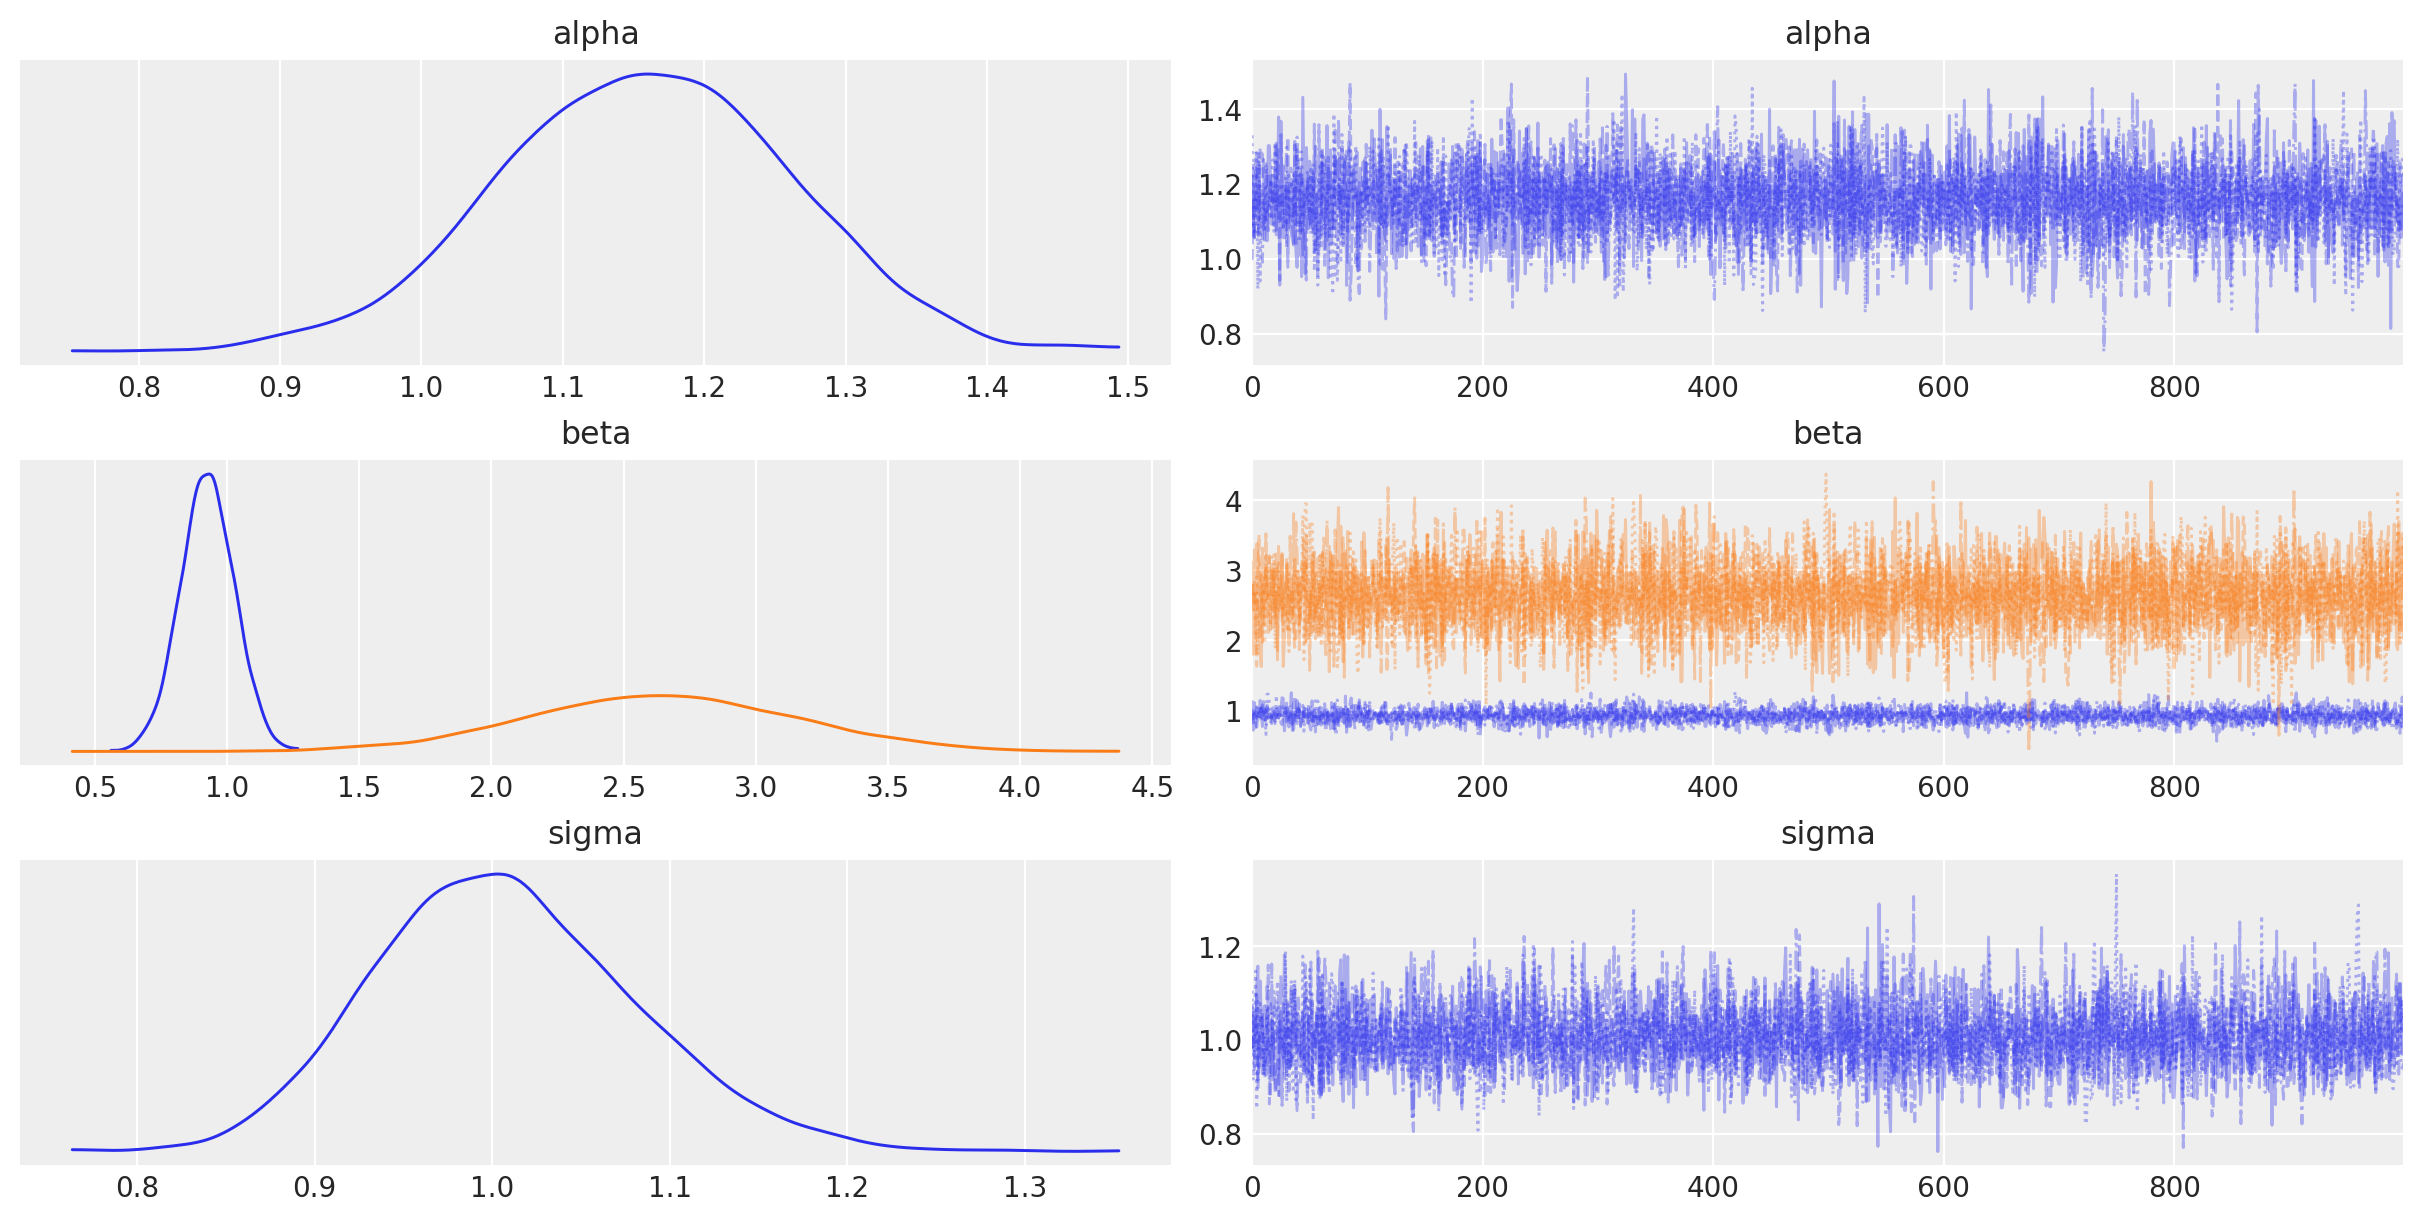

In [16]:
az.plot_trace(idata, combined=True);

In [17]:
az.summary(idata, round_to=2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,1.16,0.10,0.98,1.36,0.00,0.0,5564.31,3063.75,1.0
beta[0],0.93,0.10,0.73,1.12,0.00,0.0,5600.72,3264.84,1.0
beta[1],2.64,0.51,1.76,3.65,0.01,0.0,5761.89,3160.86,1.0
sigma,1.01,0.07,0.87,1.14,0.00,0.0,5343.73,3051.86,1.0
